<a href="https://colab.research.google.com/github/nebulia37/dl-models-from-first-principles/blob/main/4_overfitting_underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Ipython
!pip install -U pip setuptools wheel
!pip install numpy>=1.26.4
!pip install git+https://github.com/d2l-ai/d2l-en.git --no-deps

  Cloning https://github.com/d2l-ai/d2l-en.git to /tmp/pip-req-build-p92i1a_1
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-p92i1a_1
  Resolved https://github.com/d2l-ai/d2l-en.git to commit 23d7a5aecceee57d1292c56e90cce307f183bb0a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for d2l: filename=d2l-1.0.3-py3-none-any.whl size=111780 sha256=631638e6fce72e4be6e739b9fdee245e6f7ae0e4d9866e480a40f71d535d9768
  Stored in directory: /tmp/pip-ephem-wheel-cache-8wdwe3mp/wheels/d0/a6/e5/00c68a127dc2642b0b49711385669e4c3fad27e32e37b9fa5a
Successfully built d2l


In [35]:
import numpy as np
import math
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
# Use SVG plots for better rendering
d2l.use_svg_display()

features = np.random.normal(size = (n_train+n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(-1))
for i in range(max_degree):
  poly_features[:, i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale = 0.1, size = labels.shape)


In [36]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2,:], labels[:2]

(tensor([[1.3940],
         [0.0373]]),
 tensor([[1.0000e+00, 1.3940e+00, 9.7157e-01, 4.5145e-01, 1.5733e-01, 4.3861e-02,
          1.0190e-02, 2.0293e-03, 3.5359e-04, 5.4766e-05, 7.6342e-06, 9.6744e-07,
          1.1238e-07, 1.2051e-08, 1.1999e-09, 1.1150e-10, 9.7146e-12, 7.9658e-13,
          6.1689e-14, 4.5259e-15],
         [1.0000e+00, 3.7298e-02, 6.9558e-04, 8.6480e-06, 8.0639e-08, 6.0154e-10,
          3.7394e-12, 1.9925e-14, 9.2896e-17, 3.8498e-19, 1.4359e-21, 4.8689e-24,
          1.5133e-26, 4.3419e-29, 1.1568e-31, 2.8764e-34, 6.7052e-37, 1.4711e-39,
          3.0478e-42, 5.6052e-45]]),
 tensor([5.8509, 4.9499]))

In [37]:
def evaluate_loss(net, data_iter, loss):
  metric = d2l.Accumulator(2)
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [42]:
# -----train epoch-------
def train_epoch_ch3(net, train_iter, loss_fn, optimizer):
  if isinstance(net, torch.nn.Module):
    net.train()

  metric = d2l.Accumulator(3)
  for X, y in train_iter:
    optimizer.zero_grad()
    y_hat = net(X)
    l = loss_fn(y_hat, y)
    l.backward()
    optimizer.step()
    with torch.no_grad():
      metric.add(l.item()*y.size(0), (y_hat.argmax(1) == y).sum().item(), y.size(0))
  return metric[0]/metric[2], metric[1]/metric[2]

def train_ch3(net, train_iter, test_iter, loss_fn, num_epochs, lr_):
  global lr
  lr = lr_
  animator = d2l.Animator(
      xlabel="epoch",
      ylabel='metric',
      xlim = [1, num_epochs],
      legend = ['train loss', 'train acc', 'test acc']
  )
  for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch_ch3(net, train_iter, loss_fn, trainer)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch+1, (train_loss, train_acc, test_acc))
    print(f"epoch {epoch+1:2d}: train_loss = {train_loss:.4f}, train_acc={train_acc:.4f}, test_acc={test_acc:.4f}")
  plt.show()
  return train_loss, train_acc, test_acc


In [38]:
# 1. initialize weights
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)

In [48]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
  loss = nn.MSELoss()
  input_shape = train_features.shape[-1]
  net = nn.Sequential(nn.Linear(input_shape, 1, bias = False))
  net.apply(init_weights)
  batch_size = min(10, train_labels.shape[0])
  train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)), batch_size)
  test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),batch_size, is_train=False)
  trainer = torch.optim.SGD(net.parameters(), lr=0.01)
  animator = d2l.Animator(xlabel="epoch", ylabel='loss',yscale='log', xlim=[1, num_epochs], ylim=[1e-3,100], legend=['train','test'])
  for epoch in range(num_epochs):
    train_epoch_ch3(net, train_iter, loss, trainer)
    if epoch == 0 or (epoch + 1)%20==0:
      animator.add(epoch+1, (evaluate_loss(net,train_iter, loss), evaluate_loss(net, test_iter, loss)))
  print('weight:', net[0].weight.data.numpy())

weight: [[ 5.007295   1.2644788 -3.41196    5.4176474]]


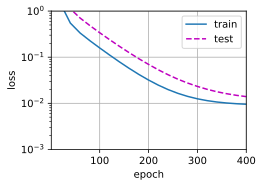

In [46]:
train(poly_features[:n_train, :4],
      poly_features[n_train:, :4],
      labels[:n_train],
      labels[n_train:])

weight: [[3.6561809 4.0496316]]


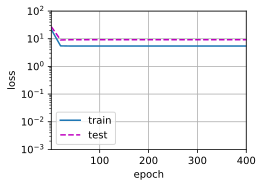

In [49]:
train(poly_features[:n_train, :2],
      poly_features[n_train:, :2],
      labels[:n_train],
      labels[n_train:])

weight: [[ 4.9795871e+00  1.3201095e+00 -3.2310441e+00  5.0861630e+00
  -5.9452415e-01  1.3305455e+00 -1.0930424e-02  1.6772223e-01
   3.4496866e-03 -4.5340025e-04  7.0170453e-03  2.0967869e-02
   1.9920217e-04  4.6571088e-03  8.7198000e-03 -8.4216809e-03
   1.6790166e-02  5.7693347e-03 -2.3190337e-03  8.3923340e-03]]


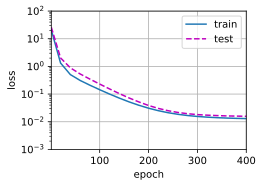

In [56]:
train(poly_features[:n_train, :],
      poly_features[n_train:, :],
      labels[:n_train],
      labels[n_train:])